# **Tổng quan**

 fine-tuning là lấy 1 pre-trained model, tận dụng 1 phần hoặc toàn bộ các layer, thêm/sửa/xoá 1 vài layer/nhánh để tạo ra 1 model mới. Thường các layer đầu của model được freeze (đóng băng) lại - tức weight các layer này sẽ không bị thay đổi giá trị trong quá trình train. Lý do bởi các layer này đã có khả năng trích xuất thông tin mức trìu tượng thấp , khả năng này được học từ quá trình training trước đó. Ta freeze lại để tận dụng được khả năng này và giúp việc train diễn ra nhanh hơn (model chỉ phải update weight ở các layer cao). Có rất nhiều các Object detect model được xây dựng dựa trên các Classifier model. VD Retina model (Object detect) được xây dựng với backbone là Resnet. 

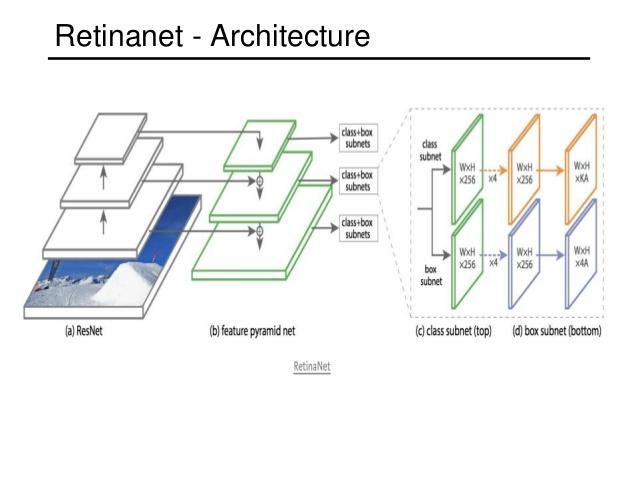

Creating helper functions


In [ ]:
# Get helper_functions.py script from course Github
!wget https://raw.githubusercontent.com/Wassefy/tensorflow/main/Extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir  


--2021-06-25 15:09:41--  https://raw.githubusercontent.com/Wassefy/tensorflow/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2021-06-25 15:09:42 (96.0 MB/s) - ‘helper_functions.py’ saved [10234/10234]



# **10 Food Classes**: Làm việc với ít dữ liệu 

Trong phần Feature Extraction, chúng ta đã thu được kết quả khá tốt chỉ với 10% của bộ dữ liệu bằng cách học chuyển giao với TensorFlow Hub.

Trong phần này, chúng ta sẽ tiếp tục làm việc với các tập con dữ liệu nhỏ hơn, ngoại trừ lần này chúng ta sẽ xem xét có thể sử dụng các mô hình được tạo sẵn trong mô-đun `tf.keras.application` cũng như cách tinh chỉnh các lớp để phù hợp với tập dữ liệu của mình.



In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-06-25 15:09:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 142.251.33.208, 172.217.9.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2021-06-25 15:09:45 (201 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Sau khi có được dữ liệu hình ảnh, chúng ta sẽ chuyển chúng sang định dạng tương thích với Tensorflow.

Trước đó, chúng ta đã sử dụng lớp `ImageDataGenerator` và hoạt động tốt. Nhưng lần này chúng ta sẽ sử dụng hàm `image_dataset_from_directory`.

Nó hoạt động giống như phương thức `flow_from_directory` của `ImageDataGenerator`, nghĩa là hình ảnh cần phải ở định dạng tệp sau:
```

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

Một trong những lợi ích chính của việc sử dụng `tf.keras.preprocessing.image_dataset_from_directory` so với `ImageDataGenerator` là nó tạo ra một đối tượng `tf.data.Dataset` hơn là một trình tạo.Ưu điểm của `tf.data.Dataset` API là nó hiệu quả hơn(nhanh hơn) so với `ImageDataGenerator` API(Điều tối quan trọng đối với các tập dữ liệu lớn).



In [ ]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = 32
)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical'
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Checking the training data datatype
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

Trong Output trên:

- `(None, 224, 224, 3)` đề cập đến hình dạng tensor ảnh của chúng ta, trong đó `None` là kích thước `batch`(lô), `224, 224` là chiều cao và chiều rộng, `3` là các kênh màu `(R, G, B)`.
- (None, 10) đề cập đến hình dạng tensor của nhãn. Trong đó, `None` là kích thước `batch`(lô) và `10` là số lượng nhãn có thể có(10 món ăn khác nhau).
- Cả bộ tensor nhãn và hình ảnh đều có kiểu dữ liệu là `float32`.

`batch_size` là `None` do nó chỉ được sử dụng trong quá trình đào tạo mô hình. Có thể coi `None` như một trình giữ chỗ chờ được lấp đầy với tham số `batch_size` từ `image_dataset_from_directory()`.

Một lợi ích khác của việc sử dụng `tf.data.Dataset API` là các phương thức liên kết đi kèm với nó.Ví dụ, nếu chúng ta muốn tìm tên của các lớp mà chúng ta đang làm việc, chúng ta có thể sử dụng thuộc tính `class_names`.

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Hoặc nếu chúng ta muốn xem một lô dữ liệu mẫu, chúng ta có thể sử dụng phương thức `take()`.

In [ ]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.02142849e+01 2.22142849e+01 1.72142849e+01]
   [1.95459175e+01 2.15459175e+01 1.65459175e+01]
   [2.12142868e+01 2.32142868e+01 1.86428566e+01]
   ...
   [2.19947968e+01 2.65662689e+01 1.95662689e+01]
   [2.01428833e+01 2.51428833e+01 1.81428833e+01]
   [1.85712891e+01 2.35712891e+01 1.65712891e+01]]

  [[1.88571434e+01 2.08571434e+01 1.58571434e+01]
   [2.01377544e+01 2.21377544e+01 1.71377544e+01]
   [2.12142868e+01 2.32142868e+01 1.86428566e+01]
   ...
   [2.16427917e+01 2.62142639e+01 1.92142639e+01]
   [2.11428699e+01 2.61428699e+01 1.91428699e+01]
   [1.81681957e+01 2.31681957e+01 1.61681957e+01]]

  [[1.77040806e+01 1.97040806e+01 1.47040815e+01]
   [2.16734695e+01 2.36734695e+01 1.86734695e+01]
   [2.10459194e+01 2.30459194e+01 1.84744892e+01]
   ...
   [2.14744415e+01 2.60459137e+01 1.90459137e+01]
   [2.13418598e+01 2.63418598e+01 1.93418598e+01]
   [1.75712891e+01 2.25712891e+01 1.55712891e+01]]

  ...

  [[2.79336853e+01 2.99336853e+01 2.50867519e+01]
   [3

Lưu ý cách các mảng hình ảnh xuất hiện dưới dạng hàng chục giá trị pixel khi các nhãn xuất hiện dưới dạng mã hóa one-hot (ví dụ: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] cho bánh hamburger) .

# **Xây dựng mô hình**

## **Model 0: Xây dựng mô hình học chuyển giao bằng Keras Functional API**

Sau khi đã tải, tiền xử lý cũng như kiểm tra dữ liệu, bây giờ chúng ta tiến hành đi xây dựng mô hình.

Để xây dựng mô hình học chuyển giao, chúng ta sẽ sử dụng modul `tf.keras.applications`, vì nó chứa một loạt các mô hình thị giác máy tính đã được đào tạo (trên ImageNet) cũng như Keras Functional API.

Các bước thực hiện:
1. Khởi tạo một đối tượng mô hình cơ sở được đào tạo trước bằng cách chọn một mô hình đích, chẳng hạn như `EfficientNetB0` từ `tf.keras.application`,đặt tham số `include_top` thành `False` (vì chúng ta sẽ tạo đỉnh của riêng mình, là các lớp đầu ra cho mô hình).
2. Đặt thuộc tính có thể đào tạo(`trainable`) của mô hình cơ sở thành `False` để cố định tất cả các trọng số trong mô hình được đào tạo trước.
3. Xác định lớp đầu vào cho mô hình của chúng ta, ví dụ, mô hình của chúng ta nên mong đợi hình dạng dữ liệu nào?
4. [Tùy chọn] Chuẩn hóa các đầu vào cho mô hình của chúng ta nếu nó yêu cầu. Một số mô hình thị giác máy tính như `ResNetV250` yêu cầu đầu vào của chúng từ 0 đến 1.
> Chú ý : Khi viết, mô hình EfficientNet trong mô-đun `tf.keras.application `không yêu cầu hình ảnh phải được chuẩn hóa (giá trị pixel từ 0 đến 1) trên đầu vào, giống như nhiều mô hình khác.
5. Chuyển các đầu vào cho mô hình cơ sở.
6. Nhóm các đầu ra của mô hình cơ sở thành một hình dạng tương thích với lớp kích hoạt đầu ra (biến bộ tensor đầu ra của mô hình cơ sở thành hình dạng giống như bộ tensor nhãn).Điều này có thể được thực hiện bằng cách sử dụng `tf.keras.layers.GlobalAveragePooling2D()` hoặc `tf.keras.layers.GlobalMaxPooling2D()`.
7. Tạo một lớp kích hoạt đầu ra bằng cách sử dụng `tf.keras.layers.Dense()` với chức năng kích hoạt và số lượng tế bào thần kinh thích hợp.
8. Kết hợp các đầu vào và đầu ra lớp thành một mô hình bằng cách sử dụng `tf.keras.Model()`.
9. Biên dịch mô hình bằng cách sử dụng chức năng mất mát thích hợp và chọn trình tối ưu hóa.
10. Hợp mô hình cho số lượng epoch mong muốn và với các lệnh gọi lại cần thiết (trong trường hợp của chúng ta, chúng ta sẽ bắt đầu với lệnh gọi lại TensorBoard).



In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB7(include_top = False)

# 2. Freeze the base model (so pre-learned patterns remain)
base_model.trainable  = False

# 3.  Create inputs into the base model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layers")

# 4. If using ResNet50V2, add this to speed up convergene, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the model 
# Note: using tf.keras.applications, EfficientNet inputs don't have to be normalized
x = base_model(inputs)
# check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model 
# aggregate all the most  important information, reduce of computations
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'After GlobalAveragePooling2D(): {x.shape}')

# 7. Create the outputs activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

# 10. Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 validation_steps = int(0.25*len(test_data_10_percent)),
                                 callbacks = [create_tensorboard_callback(
                                     "transfer_learning",
                                     "10_percent_feature_extract"
                                 )])

258080768/258076736 [==============================] - 2s 0us/step
Shape after base_model: (None, 7, 7, 2560)
After GlobalAveragePooling2D(): (None, 2560)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210625-151001


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 72s 1s/step - loss: 1.6306 - accuracy: 0.5533 - val_loss: 0.9944 - val_accuracy: 0.7878
Epoch 2/5
24/24 [==============================] - 20s 817ms/step - loss: 0.8649 - accuracy: 0.8120 - val_loss: 0.7072 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 20s 820ms/step - loss: 0.6496 - accuracy: 0.8440 - val_loss: 0.6283 - val_accuracy: 0.8240
Epoch 4/5
24/24 [==============================] - 17s 711ms/step - loss: 0.5542 - accuracy: 0.8533 - val_loss: 0.5858 - val_accuracy: 0.8240
Epoch 5/5
24/24 [==============================] - 20s 824ms/step - loss: 0.4804 - accuracy: 0.8947 - val_loss: 0.5613 - val_accuracy: 0.8339


Sau hơn 1 phút đào tạo mô hình của chúng ta đã hoạt động cực kỳ tốt trên cả tập huấn luyện và tập thử nghiệm (85%+)

Điều quan trọng cần lưu ý là loại học chuyển giao mà chúng ta sử dụng ở đây được gọi là học chuyển đổi trích xuất tính năng, tương tự như những gì chúng ta đã làm với các mô hình TensorFlow Hub.Nói cách khác, chúng ta đã chuyển dữ liệu tùy chỉnh của mình sang một mô hình đã được đào tạo trước (EfficientNetB0), hỏi nó "bạn thấy những mẫu nào?" và sau đó đặt lớp đầu ra của chính chúng ta lên trên để đảm bảo kết quả đầu ra được điều chỉnh cho phù hợp với số lớp mong muốn của chúng ta.

Chúng ta đã sử dụng Keras Functional API để xây dựng mô hình thay vì Sequential API. Hiện tại lợi ích của phương pháp này chưa rõ ràng nhưng khi ta bắt đầu xây dựng các mô hình phức tạp hơn, có thể sẽ cần sử dụng Functional API. Vì vậy điều quan trọng là phải tiếp xúc với cách xây dựng mô hình này.

Hãy kiểm tra các lớp trong mô hình của chúng ta, chúng ta sẽ bắt đầu với phần cơ sở.

In [ ]:
# check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block1b_dwconv
18 block1b_bn
19 block1b_activation
20 block1b_se_squeeze
21 block1b_se_reshape
22 block1b_se_reduce
23 block1b_se_expand
24 block1b_se_excite
25 block1b_project_conv
26 block1b_project_bn
27 block1b_drop
28 block1b_add
29 block1c_dwconv
30 block1c_bn
31 block1c_activation
32 block1c_se_squeeze
33 block1c_se_reshape
34 block1c_se_reduce
35 block1c_se_expand
36 block1c_se_excite
37 block1c_project_conv
38 block1c_project_bn
39 block1c_drop
40 block1c_add
41 block1d_dwconv
42 block1d_bn
43 block1d_activation
44 block1d_se_squeeze
45 block1d_se_reshape
46 block1d_se_reduce
47 block1d_se_expand
48 block1d_se_excite
49 block1d_project_conv
50 block1d_project_bn
51 block1d_drop
52 

Chà, đó là rất nhiều lớp ... để viết tay tất cả những lớp đó sẽ mất một thời gian khá dài để thực hiện, nhưng chúng ta vẫn có thể cải tiến chúng nhờ vào sức mạnh của việc học chuyển giao.

In [ ]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

Có thể thấy mỗi lớp khác nhau có một số tham số nhất định như thế nào. Vì chúng ta đang sử dụng một mô hình được đào tạo trước, có thể hiểu rằng tất cả các tham số này là các mẫu mà mô hình cơ sở đã học được trên một tập dữ liệu khác. Và bởi vì chúng ta đặt `base_model.trainable = False`, các mẫu này vẫn như cũ trong quá trình đào tạo (chúng bị đóng băng và không được cập nhật).

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layers (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling_layer (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                25610     
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
_________________________________________________________________


Mô hình tổng thể của chúng ta có năm lớp nhưng thực sự, một trong những lớp đó (EfficientNet) có 812 lớp.

Có thể thấy hình dạng đầu ra bắt đầu  là `(None, 224, 224, 3)` cho lớp đầu vào (hình dạng của các hình ảnh của chúng ta) nhưng đã được biến đổi thành `(None, 10)` bởi lớp đầu ra (hình dạng của các nhãn của chúng ta ), trong đó `None` là trình giữ chỗ cho `batch_size`.

Lưu ý rằng, các tham số duy nhất có thể đào tạo trong mô hình là các tham số trong lớp đầu ra.


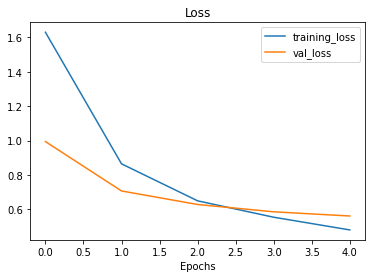

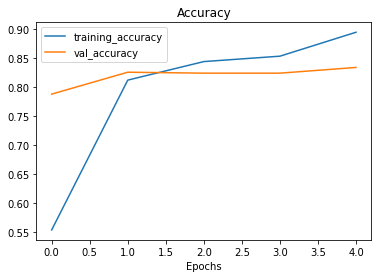

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

# **Lấy một vectơ đặc trưng từ một mô hình được đào tạo**

Điều gì xảy ra khi triển khai lớp `tf.keras.layers.GlobalAveragePooling2D()`?

Lớp `tf.keras.layers.GlobalAveragePooling2D()` biến tensor 4D thành tensor 2D bằng cách lấy trung bình các giá trị trên các trục bên trong.



In [ ]:
# Define input tensor shape( same number of dimensions as the output of EfficientNetB0)
input_shape = (1, 3, 4, 2)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor} \n')

# Pass the random tensor through a global average pooling  2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shapes of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of 2D global average pooled random tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258 ]
   [ 0.3194337  -1.4075519 ]
   [-2.3880599  -1.0392479 ]
   [-0.5573232   0.539707  ]]

  [[ 1.6994323   0.28893656]
   [-1.5066116  -0.2645474 ]
   [-0.59722406 -1.9171132 ]
   [-0.62044144  0.8504023 ]]

  [[-0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987]
   [-0.22561555 -0.7616443 ]
   [-1.8917141  -0.93847126]]]] 

2D global average pooled random tensor:
 [[-0.41173807 -0.68495303]]

Shape of input tensor: (1, 3, 4, 2)
Shape of 2D global average pooled random tensor: (1, 2)


Lớp `tf.keras.layers.GlobalAveragePooling2D()` đã cô đặc tensor đầu vào từ hình dạng (1, 4, 4, 3) thành (1, 3). Nó đã làm như vậy bằng cách lấy trung bình input_tensor qua hai trục giữa.



# **Chạy một loạt các thử nghiệm học tập chuyển giao**

Chúng ta đã thấy kết quả đáng kinh ngạc của việc học chuyển giao trên 10% dữ liệu đào tạo, còn 1% dữ liệu đào tạo thì sao?

Loại kết quả nào mà chúng ta có thể nhận được khi sử dụng dữ liệu ít hơn 100 lần so với mô hình CNN ban đầu mà chúng tôa tự xây dựng?

Chúng ta sẽ trả lời hai câu hỏi trên bằng cách chạy các mô hình thử nghiệm sau:
1. model_1: Sử dụng học chuyển giao trích xuất tính năng với 1% dữ liệu đào tạo được tăng cường.
2. model_2: Sử dụng học chuyển giao trích xuất tính tăng với 10% dữ liệu đào tạo được tăng cường.
3. model_3: Sử dụng học chuyển giao tinh chỉnh với 10% dữ liệu đào tạo được tăng cường.
4. model_4: Sử dụng học chuyển giao tinh chỉnh với toàn bộ dữ liệu đào tạo được tăng cường.

Mặc dù tất cả các thử nghiệm sẽ được chạy trên các phiên bản khác nhau của dữ liệu đào tạo, nhưng tất cả chúng sẽ được đánh giá trên cùng một tập dữ liệu thử nghiệm, điều này đảm bảo kết quả của mỗi thử nghiệm có thể so sánh được với nhau.

Tất cả các thử nghiệm sẽ được thực hiện bằng cách sử dụng mô hình EfficientNetB0 trong mô-đun `tf.keras.application`.

Hãy bắt đầu bằng cách tải xuống dữ liệu cho thử nghiệm 1, sử dụng tính năng học chuyển đổi trích xuất trên 1% dữ liệu đào tạo có tăng cường dữ liệu.


In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2021-06-25 15:12:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   158MB/s    in 0.8s    

2021-06-25 15:12:31 (158 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


**Thêm dữ liệu tăng cường vào mô hình**

Trước đây, chúng ta đã sử dụng các tham số khác nhau của lớp `ImageDataGenerator` để tăng cường hình ảnh đào tạo của chúng ta, lần này chúng ta sẽ xây dựng tăng cường dữ liệu ngay trong mô hình. Bằng cách sử dụng mô-đun `tf.keras.layers.experimental.preprocessing` và tạo một lớp tăng dữ liệu chuyên dụng.
Đây là một tính năng tương đối mới được thêm vào TensorFlow 2.2+ nhưng nó rất mạnh mẽ. Việc thêm một lớp tăng dữ liệu vào mô hình có những lợi ích sau:
- Việc xử lý trước hình ảnh (tăng cường chúng) xảy ra trên GPU chứ không phải trên CPU (nhanh hơn nhiều).Hình ảnh được xử lý trước tốt nhất trên GPU khi văn bản và dữ liệu có cấu trúc phù hợp hơn để được xử lý trước trên CPU.
- Việc tăng dữ liệu hình ảnh chỉ xảy ra trong quá trình đào tạo nên chúng ta vẫn có thể xuất toàn bộ mô hình của mình và sử dụng nó ở nơi khác. Và nếu ai đó muốn đào tạo mô hình tương tự như chúng ta, bao gồm cùng một loại tăng dữ liệu, họ có thể.

Để sử dụng tăng dữ liệu ngay trong mô hình, chúng ta sẽ tạo mô hình Keras Sequential chỉ bao gồm các lớp tiền xử lý dữ liệu, sau đó chúng ta có thể sử dụng mô hình Sequential này trong một mô hình Functional khác.

Các phép biến đổi tăng dữ liệu mà chúng tôi sẽ sử dụng là:
- RandomFlip: lật hình ảnh trên trục ngang hoặc trục dọc.
- RandomRotation: xoay ngẫu nhiên hình ảnh theo một hệ số chỉ định.
- RandomZoom: phóng to ngẫu nhiên vào một hình ảnh theo hệ số chỉ định.
- RandomHeight: thay đổi ngẫu nhiên chiều cao hình ảnh theo một hệ số chỉ định.
- RandomWidth: thay đổi ngẫu nhiên chiều rộng hình ảnh theo một hệ số chỉ định.
- Rescaling: chuẩn hóa các giá trị pixel hình ảnh thành từ 0 đến 1, điều này  là bắt buộc đối với một số mô hình hình ảnh nhưng vì chúng ta đang sử dụng triển khai `tf.keras.appalications` của EfficientNetB0, nên nó không bắt buộc.



In [ ]:
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      # preprocessing.Rescaling(1./255) # Keep  for ResNet50V2
], name = 'data_augmentation')


Mô hình tuần tự tăng dữ liệu của chúng ta đã sẵn sàng hoạt động.Sau đó, chúng ta sẽ có thể sắp xếp "mô hình" này như một lớp vào mô hình học chuyển giao của chúng ta sau này.


Nhưng trước khi làm điều đó, hãy kiểm tra nó bằng cách chuyển các hình ảnh ngẫu nhiên qua nó.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 608.5, 553.5, -0.5)

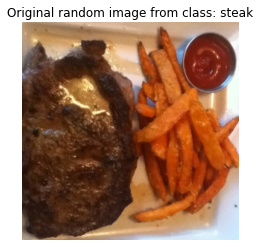

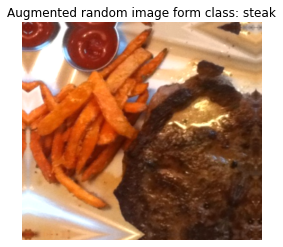

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)    # choose a random class
target_dir  = '10_food_classes_1_percent/train/'+ target_class    # create the target directory
random_image = random.choice(os.listdir(target_dir))              # choose a random image from target directory
random_image_path = target_dir + "/" + random_image              # create the choosen random image path
img = mpimg.imread(random_image_path)                             # read in the choosen target image
plt.imshow(img)                                                   # Plot the target image
plt.title(f'Original random image from class: {target_class}')
plt.axis(False)

# Augment the image
augment_img = data_augmentation(tf.expand_dims(img, axis = 0))    # data augmentation model requires shape (None, Height, Width, 3)
plt.figure()
plt.imshow(tf.squeeze(augment_img)/225.)                          # requires normalization after augmentation
plt.title(f'Augmented random image form class: {target_class}')
plt.axis(False)



## Model_1: **Học chuyển giao trích xuất tính năng với 1% dữ liệu đào tạo được tăng cường**

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top = False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# give base_model inputs(after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Put a Dense layer as on the output
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy']
                )
# Fit the model
history_1_percent = model_1.fit(train_data_1_percent, epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback(
                                              "transfer_learning",
                                              '1_percent_data_aug'   
                                             )])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210625-153323


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 33s 9s/step - loss: 2.2612 - accuracy: 0.1714 - val_loss: 2.1127 - val_accuracy: 0.3306
Epoch 2/5
3/3 [==============================] - 13s 6s/step - loss: 1.9560 - accuracy: 0.5000 - val_loss: 1.9571 - val_accuracy: 0.4391
Epoch 3/5
3/3 [==============================] - 12s 6s/step - loss: 1.7646 - accuracy: 0.7000 - val_loss: 1.8143 - val_accuracy: 0.5263
Epoch 4/5
3/3 [==============================] - 13s 6s/step - loss: 1.5251 - accuracy: 0.7571 - val_loss: 1.7149 - val_accuracy: 0.5428
Epoch 5/5
3/3 [==============================] - 13s 6s/step - loss: 1.3991 - accuracy: 0.8286 - val_loss: 1.5933 - val_accuracy: 0.5905


Chỉ sử dụng 7 hình ảnh đào tạo cho mỗi lớp, bằng cách sử dụng học chuyển đổi, mô hình của chúng tôi có thể đạt được độ chính xác ~ 60% trên bộ xác thực. Kết quả này khá tuyệt vời vì [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)  ban đầu đạt độ chính xác 50,67% với tất cả dữ liệu, cụ thể là 750 hình ảnh đào tạo cho mỗi lớp.

In [ ]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling_layer (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                25610     
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
_________________________________________________________________


Bây giờ chúng ta đã có phần tăng dữ liệu được tích hợp ngay trong mô hình của chúng ta. Điều này có nghĩa là nếu chúng ta đã lưu nó và tải lại nó ở một nơi khác, các lớp tăng dữ liệu sẽ đi kèm với nó.

Điều quan trọng cần nhớ là dữ liệu tăng chỉ chạy trong quá trình đào tạo. Vì vậy, nếu chúng ta đánh giá hoặc sử dụng mô hình để suy luận (dự đoán lớp của một hình ảnh), các lớp tăng dữ liệu sẽ tự động bị tắt.

Để xem điều này trong thực tế, hãy đánh giá mô hình của chúng tôi trên dữ liệu thử nghiệm.

In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 32s 402ms/step - loss: 1.6052 - accuracy: 0.5760


[1.6051998138427734, 0.5759999752044678]

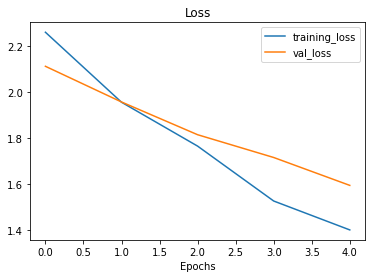

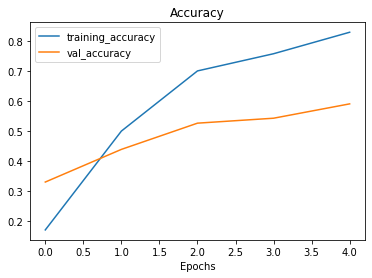

In [ ]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

## **Model_2: Học chuyển giao trích xuất dữ liệu với 10% dữ liệu đào tạo được tăng cường**

In [ ]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Tạo một ModelCheckpoint callback**

Đối với thử nghiệm này, chúng ta sẽ giới thiệu một lệnh gọi lại mới, lệnh gọi lại ModelCheckpoint.

Lệnh gọi lại ModelCheckpoint cung cấp khả năng lưu toàn bộ mô hình ở định dạng SavedModel hoặc chỉ trọng số (mẫu) vào một thư mục được chỉ định khi nó đào tạo.

Điều này rất hữu ích nếu ta nghĩ rằng mô hình của mình sẽ được đào tạo trong một thời gian dài và muốn sao lưu mô hình của mình khi nó đào tạo. Điều đó cũng có nghĩa là nếu ta nghĩ rằng mô hình của mình có thể được lợi khi được đào tạo lâu hơn, bạn có thể tải lại mô hình đó từ một điểm kiểm tra cụ thể và tiếp tục đào tạo từ đó.Ví dụ: giả sử chúng ta hợp với mô hình học tập chuyển đổi trích xuất tính năng trong 5 epoch và kiểm tra các đường cong đào tạo và thấy nó vẫn đang được cải thiện và ta muốn xem liệu việc tinh chỉnh thêm 5 epoch nữa có thể giúp ích được gì không,chúng ta có thể tải điểm kiểm tra, giải nén một số (hoặc tất cả) các lớp mô hình cơ sở và sau đó tiếp tục đào tạo.





In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

Sự khác biệt giữa lưu toàn bộ mô hình (định dạng SavedModel) và chỉ lưu trọng số là gì?

Định dạng SavedModel lưu toàn bộ kiến ​​trúc, trọng số và cấu hình đào tạo của mô hình trong một thư mục. Nó giúp ta dễ dàng tải lại mô hình của mình một cách chính xác như thế nào ở nơi khác. Tuy nhiên, nếu không muốn chia sẻ tất cả những thông tin chi tiết này với người khác, ta có thể chỉ muốn lưu và chia sẻ trọng số. Nếu dung lượng ổ đĩa là một vấn đề, chỉ lưu trọng số sẽ nhanh hơn và chiếm ít dung lượng hơn so với lưu toàn bộ mô hình.


Bây giờ hãy tiến hành hợp mô hình. Bởi vì chúng ta sẽ tinh chỉnh nó sau,nên chúng ta sẽ tạo một biến `initial_epochs` và đặt nó thành 5 để sử dụng sau này.

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback(
                                              "transfer_learning", "10_percent_data_aug"), 
                                              checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210625-151511


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
24/24 [==============================] - 57s 2s/step - loss: 1.8369 - accuracy: 0.4147 - val_loss: 1.1193 - val_accuracy: 0.7763

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 33s 1s/step - loss: 1.1240 - accuracy: 0.6947 - val_loss: 0.7529 - val_accuracy: 0.8306

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.9186 - accuracy: 0.7440 - val_loss: 0.6748 - val_accuracy: 0.8207

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 32s 1s/step - loss: 0.7979 - accuracy: 0.7707 - val_loss: 0.5818 - val_accuracy: 0.8405

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 29s 1s/step - loss: 0.7021 - accuracy: 0.8133 - val_loss:

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 32s 404ms/step - loss: 0.5865 - accuracy: 0.8356


[0.5865486860275269, 0.8356000185012817]

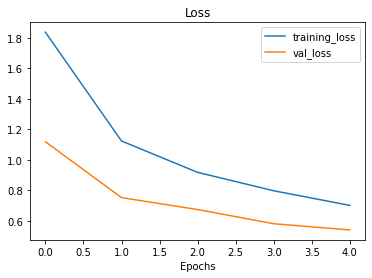

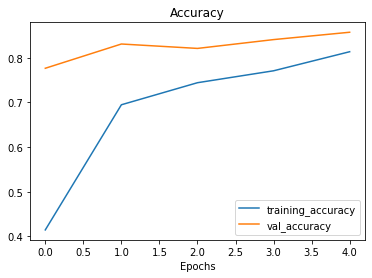

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

Nhìn vào đồ thị, hiệu suất của mô hình của chúng ta với 10% dữ liệu và tăng dữ liệu không tốt bằng mô hình có 10% dữ liệu không tăng dữ liệu (xem kết quả model_0 ở trên), tuy nhiên, các đường cong đang có xu hướng đi đúng hướng, nghĩa là nếu chúng ta quyết định đào tạo lâu hơn, các chỉ số của nó có thể sẽ được cải thiện.

Vì chúng ta đã lưu lại các trọng số của mô hình, nên có thể tải lại để kiểm tra xem nó có được lưu chính xác không bằng cách đánh giá nó trên bộ  dữ liệu thử nghiệm.Để tải trọng lượng mô hình đã lưu,có thể sử dụng phương thức `load_weights()`, chuyển nó đến đường dẫn nơi lưu trữ trọng lượng đã lưu.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 32s 405ms/step - loss: 0.5865 - accuracy: 0.8356


Bây giờ chúng ta hãy so sánh kết quả của mô hình được đào tạo trước đó của chúng ta và mô hình được tải. Những kết quả này sẽ rất gần nếu không phải là hoàn toàn giống nhau. Lý do cho những khác biệt nhỏ là do mức độ chính xác của các con số được tính toán.

In [ ]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

Nếu ô ở trên không xuất ra `True`, thì đó là do các số gần nhau nhưng không giống nhau chính xác (do cách máy tính lưu trữ các số với mức độ chính xác). Tuy nhiên chúng vẫn rất gần nhau

In [ ]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.78813934e-07 0.00000000e+00]


## **Model_3: Học chuyển giao tinh chỉnh mô hình hiện có với 10% dữ liệu**

Cho đến nay, mô hình đã lưu của chúng ta đã được đào tạo bằng cách sử dụng học chuyển giao trích xuất tính năng trong 5 epoch trên 10% dữ liệu đào tạo tăng cường.Điều này có nghĩa là tất cả các lớp trong mô hình cơ sở (EfficientNetB7) đã bị đóng băng trong quá trình đào tạo.Đối với thử nghiệm tiếp theo của chúng ta, sẽ chuyển sang học chuyển giao tinh chỉnh. Điều này có nghĩa là chúng ta sẽ sử dụng cùng một mô hình cơ sở và sẽ mở một số lớp của nó (những lớp gần nhất) và chạy mô hình trong một vài epoch nữa.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, None, None, 2560)  64097687  
_________________________________________________________________
global_average_pooling_layer (None, 2560)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                25610     
Total params: 64,123,297
Trainable params: 25,610
Non-trainable params: 64,097,687
_________________________________________________________________


Có vẻ như tất cả các lớp trong lớp Effectsnetb7 đã bị đóng băng. Chúng ta có thể xác nhận điều này bằng thuộc tính trainable_variables.

In [ ]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


Điều này giống với mô hình cơ sở của chúng ta.

In [ ]:
print(len(base_model.trainable_variables))


0


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop Fal

Bây giờ để tinh chỉnh mô hình cơ sở phù hợp với dữ liệu của chúng ta, chúng ta sẽ giải phóng 10 lớp trên cùng và tiếp tục đào tạo mô hình của chúng tôi trong 5 epoch khác.Điều này có nghĩa là tất cả các lớp của mô hình cơ sở ngoại trừ 10 lớp cuối cùng sẽ vẫn bị đóng băng và không thể kiểm tra được. Và trọng lượng ở các lớp chưa đóng băng còn lại sẽ được cập nhật trong quá trình đào tạo.

**Câu hỏi**: Nên mở bao nhiêu lớp khi đào tạo?

Không có quy tắc thiết lập cho điều này.Có thể giải phóng mọi lớp trong mô hình được đào tạo trước hoặc có thể thử mở từng lớp một. Tốt nhất hãy thử nghiệm với các lượng mở rộng và tinh chỉnh khác nhau để xem điều gì sẽ xảy ra. Nói chung,  càng có ít dữ liệu thì càng ít lớp cần giải phóng và tinh chỉnh dần dần.

Để bắt đầu tinh chỉnh, chúng ta sẽ giải phóng toàn bộ mô hình cơ sở bằng cách đặt thuộc tính `trainable` của nó thành `True`. Sau đó, chúng ta sẽ đóng băng lại mọi lớp trong mô hình cơ sở ngoại trừ 10 lớp cuối cùng bằng cách lặp qua chúng và đặt thuộc tính `trainable` của chúng thành `False`. Cuối cùng, chúng ta sẽ biên dịch lại mô hình.


In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop Fal

Có vẻ như tất cả các lớp ngoại trừ 10 lớp cuối cùng đều bị đóng băng và không thể kiểm tra được. Điều này có nghĩa là chỉ 10 lớp cuối cùng của mô hình cơ sở cùng với lớp đầu ra sẽ được cập nhật trọng số của chúng trong quá trình đào tạo.

>**Câu hỏi:** Tại sao chúng ta cần biên dịch lại mô hình?

>Mỗi khi thực hiện thay đổi đối với mô hình của mình,chúng ta cần phải biên dịch lại chúng.

Trong trường hợp của chúng ta, chúng ta đang sử dụng chính xác mất mát, trình tối ưu hóa và số liệu như trước đây, ngoại trừ lần này tỷ lệ học tập cho trình tối ưu hóa của chúng ta sẽ nhỏ hơn 10 lần so với trước đây (0,0001 thay vì mặc định của Adam là 0,001).Chúng ta làm điều này để mô hình không cố gắng ghi đè các trọng số hiện có trong mô hình được đào tạo trước quá nhanh. Nói cách khác, chúng ta muốn học dần dần

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               # start from previous last epoch
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], 
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback(
                                                   "transfer_learning", 
                                                   # name experiment appropriately
                                                   "10_percent_fine_tune_last_10")]) 

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210625-173100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
24/24 [==============================] - 28s 1s/step - loss: 0.3915 - accuracy: 0.8853 - val_loss: 0.5137 - val_accuracy: 0.8355
Epoch 6/10
24/24 [==============================] - 25s 1s/step - loss: 0.3475 - accuracy: 0.9053 - val_loss: 0.4969 - val_accuracy: 0.8289
Epoch 7/10
24/24 [==============================] - 25s 1s/step - loss: 0.3075 - accuracy: 0.9053 - val_loss: 0.4431 - val_accuracy: 0.8470
Epoch 8/10
24/24 [==============================] - 24s 1s/step - loss: 0.2859 - accuracy: 0.9093 - val_loss: 0.4807 - val_accuracy: 0.8289
Epoch 9/10
24/24 [==============================] - 25s 1s/step - loss: 0.2564 - accuracy: 0.9173 - val_loss: 0.5320 - val_accuracy: 0.8207
Epoch 10/10
24/24 [==============================] - 26s 1s/step - loss: 0.2638 - accuracy: 0.9200 - val_loss: 0.4752 - val_accuracy: 0.8487


Độ chính xác của mô hình tăng đáng kể lên hơn 90%

In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 31s 384ms/step - loss: 0.4959 - accuracy: 0.8336


Hãy nhớ rằng, kết quả từ việc đánh giá mô hình có thể hơi khác so với kết quả đầu ra từ quá trình đào tạo vì trong quá trình đào tạo, chúng ta chỉ đánh giá trên 25% dữ liệu thử nghiệm.

Chúng ta cần một cách để đánh giá hiệu suất của mô hình trước và sau khi tinh chỉnh. 

In [ ]:
def compare_history(original_history, new_history, initial_epochs = 5):
  """
  compares two model history objects
  """
  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  print(len(acc))

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  #Combine original history with new history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  print(len(total_acc))
  print(total_acc)

  # Make plots
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = 'Training Accuracy')
  plt.plot(total_val_acc, label = 'Validation Accuracy')
  plt.plot([initial_epochs - 1, initial_epochs - 1],
           plt.ylim(), label = 'Start Fine Tuning')
  plt.legend(loc = 'lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

5
11
[0.41466665267944336, 0.6946666836738586, 0.7440000176429749, 0.7706666588783264, 0.8133333325386047, 0.8853333592414856, 0.9053333401679993, 0.9053333401679993, 0.909333348274231, 0.9173333048820496, 0.9200000166893005]


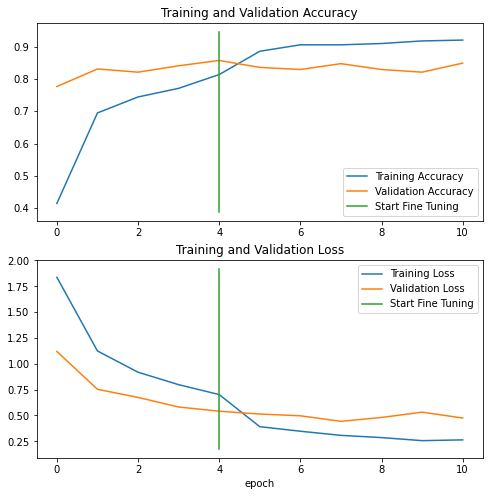

In [ ]:
compare_history(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

## **Model_4: Học chuyển giao tinh chỉnh với toàn bộ giữ liệu**

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2021-06-25 17:52:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.15.80, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   273MB/s    in 1.8s    

2021-06-25 17:52:45 (273 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path) # revert model back to saved weights

NameError: ignored